# Winner World Cup 2022 Prediction ⚽

## Install and Import Necessary Libraries

In [1]:
# pip install -qU pip sagemaker pandas numpy

In [2]:
import sagemaker, boto3, re
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.session import s3_input,  Session
from sagemaker.inputs import TrainingInput
from sagemaker.debugger import Rule, rule_configs
from sagemaker.serializers import CSVSerializer

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report

import warnings
warnings.filterwarnings('ignore')

## Load data

In [3]:
df = pd.read_csv('international_matches.csv')
df.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,tournament,city,country,neutral_location,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,1993-08-08,Bolivia,Uruguay,South America,South America,59,22,0,0,3,1,FIFA World Cup qualification,La Paz,Bolivia,False,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-08-08,Brazil,Mexico,South America,North America,8,14,0,0,1,1,Friendly,Maceió,Brazil,False,No,Draw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-08-08,Ecuador,Venezuela,South America,South America,35,94,0,0,5,0,FIFA World Cup qualification,Quito,Ecuador,False,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993-08-08,Guinea,Sierra Leone,Africa,Africa,65,86,0,0,1,0,Friendly,Conakry,Guinea,False,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-08-08,Paraguay,Argentina,South America,South America,67,5,0,0,1,3,FIFA World Cup qualification,Asunción,Paraguay,False,No,Lose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Preprocessing

In [4]:
df['date'] = pd.to_datetime(df['date'])

In [5]:
df.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,tournament,city,country,neutral_location,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,1993-08-08,Bolivia,Uruguay,South America,South America,59,22,0,0,3,1,FIFA World Cup qualification,La Paz,Bolivia,False,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-08-08,Brazil,Mexico,South America,North America,8,14,0,0,1,1,Friendly,Maceió,Brazil,False,No,Draw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-08-08,Ecuador,Venezuela,South America,South America,35,94,0,0,5,0,FIFA World Cup qualification,Quito,Ecuador,False,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993-08-08,Guinea,Sierra Leone,Africa,Africa,65,86,0,0,1,0,Friendly,Conakry,Guinea,False,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-08-08,Paraguay,Argentina,South America,South America,67,5,0,0,1,3,FIFA World Cup qualification,Asunción,Paraguay,False,No,Lose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df['home_team_goalkeeper_score'[0:9]]

0               Bolivia
1                Brazil
2               Ecuador
3                Guinea
4              Paraguay
              ...      
23916           Moldova
23917     Liechtenstein
23918             Chile
23919             Japan
23920    Korea Republic
Name: home_team, Length: 23921, dtype: object

#### Filling Missing Values

In [7]:
contains_missing_values = ['home_team_goalkeeper_score', 'home_team_mean_defense_score', 'home_team_mean_offense_score', 'home_team_mean_midfield_score', 
                           'away_team_goalkeeper_score', 'away_team_mean_defense_score', 'away_team_mean_offense_score', 'away_team_mean_midfield_score']

WC22_teams = ['Qatar', 'Ecuador', 'Senegal', 'Netherlands',
              'England', 'Iran', 'USA', 'Wales',
              'Argentina', 'Saudi Arabia', 'Mexico', 'Poland', 
              'France', 'Australia', 'Denmark', 'Tunisia',
              'Spain', 'Costa Rica', 'Germany', 'Japan',
              'Belgium', 'Canada', 'Morocco', 'Croatia',
              'Brazil', 'Serbia', 'Switzerland', 'Cameroon',
              'Portugal', 'Ghana', 'Uruguay', 'Korea Republic']

for x in WC22_teams:
    for y in contains_missing_values:
        df[y].fillna(df[df[y[0:9]] == x][y].mean(), inplace = True)

df.isna().sum()

date                             0
home_team                        0
away_team                        0
home_team_continent              0
away_team_continent              0
home_team_fifa_rank              0
away_team_fifa_rank              0
home_team_total_fifa_points      0
away_team_total_fifa_points      0
home_team_score                  0
away_team_score                  0
tournament                       0
city                             0
country                          0
neutral_location                 0
shoot_out                        0
home_team_result                 0
home_team_goalkeeper_score       0
away_team_goalkeeper_score       0
home_team_mean_defense_score     0
home_team_mean_offense_score     0
home_team_mean_midfield_score    0
away_team_mean_defense_score     0
away_team_mean_offense_score     0
away_team_mean_midfield_score    0
dtype: int64

## EDA

### General Descriptive Analysis

In [8]:
df.describe()

,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
count,23921.000000,23921.000000,23921.000000,23921.000000,23921.000000,23921.000000,23921.000000,23921.000000,23921.000000,23921.000000,23921.000000,23921.000000,23921.000000,23921.000000
mean,77.854688,80.797375,323.401488,315.453576,1.609214,1.068266,72.446016,72.586835,72.053126,75.539184,75.229214,71.929967,75.372942,75.073677
std,52.355225,53.232902,500.825725,490.944273,1.630127,1.263944,5.199913,4.924266,3.956137,3.744432,3.567424,3.744820,3.655867,3.539492
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,47.000000,47.000000,52.800000,53.300000,54.200000,52.800000,53.300000,54.200000
25%,33.000000,36.000000,0.000000,0.000000,0.000000,0.000000,71.088608,71.755319,70.677528,75.384810,74.887342,70.776471,75.347872,74.980851
50%,71.000000,73.000000,0.000000,0.000000,1.000000,1.000000,71.088608,71.755319,70.677528,75.384810,74.887342,70.776471,75.347872,74.980851
75%,115.000000,119.000000,547.000000,523.000000,2.000000,2.000000,71.088608,71.755319,70.800000,75.384810,74.887342,70.776471,75.347872,74.980851
max,211.000000,211.000000,2164.000000,2164.000000,31.000000,21.000000,97.000000,97.000000,91.800000,93.000000,93.200000,91.800000,93.000000,93.200000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23921 entries, 0 to 23920
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           23921 non-null  datetime64[ns]
 1   home_team                      23921 non-null  object        
 2   away_team                      23921 non-null  object        
 3   home_team_continent            23921 non-null  object        
 4   away_team_continent            23921 non-null  object        
 5   home_team_fifa_rank            23921 non-null  int64         
 6   away_team_fifa_rank            23921 non-null  int64         
 7   home_team_total_fifa_points    23921 non-null  int64         
 8   away_team_total_fifa_points    23921 non-null  int64         
 9   home_team_score                23921 non-null  int64         
 10  away_team_score                23921 non-null  int64         
 11  tournament     

In [10]:
df.columns

Index(['date', 'home_team', 'away_team', 'home_team_continent',
       'away_team_continent', 'home_team_fifa_rank', 'away_team_fifa_rank',
       'home_team_total_fifa_points', 'away_team_total_fifa_points',
       'home_team_score', 'away_team_score', 'tournament', 'city', 'country',
       'neutral_location', 'shoot_out', 'home_team_result',
       'home_team_goalkeeper_score', 'away_team_goalkeeper_score',
       'home_team_mean_defense_score', 'home_team_mean_offense_score',
       'home_team_mean_midfield_score', 'away_team_mean_defense_score',
       'away_team_mean_offense_score', 'away_team_mean_midfield_score'],
      dtype='object')

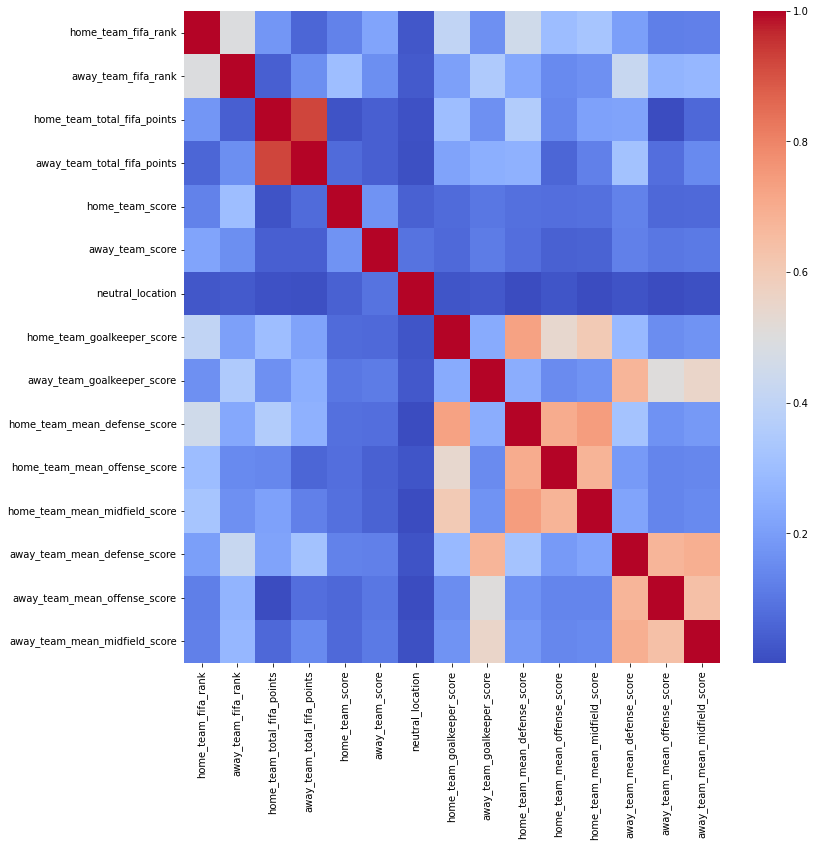

In [11]:
plt.figure(figsize=(12,12))
sns.heatmap(abs(df.corr()), cmap="coolwarm")
plt.show()

#### Top 10 Teams By Rank

In [12]:
fifa_rank = df[['date', 'home_team', 'away_team', 'home_team_fifa_rank', 'away_team_fifa_rank', 'home_team_total_fifa_points', 'away_team_total_fifa_points']]
home = fifa_rank[['date', 'home_team', 'home_team_fifa_rank', 'home_team_total_fifa_points']].rename(columns = {'home_team' : 'team', 'home_team_fifa_rank' : 'rank', 'home_team_total_fifa_points' : 'rank_points'})
away = fifa_rank[['date', 'away_team', 'away_team_fifa_rank', 'away_team_total_fifa_points']].rename(columns = {'away_team' : 'team', 'away_team_fifa_rank' : 'rank', 'away_team_total_fifa_points' : 'rank_points'})
fifa_rank = home.append(away)
fifa_rank = fifa_rank.sort_values(['team', 'date'], ascending = [True, False])
fifa_rank['row_number'] = fifa_rank.groupby('team').cumcount() + 1     
fifa_rank_top = fifa_rank[fifa_rank['row_number'] == 1].drop('row_number', axis = 1).nsmallest(10, 'rank')
fifa_rank_top

,date,team,rank,rank_points
23760,2022-06-06,Brazil,1,1832
23909,2022-06-14,Belgium,2,1827
23885,2022-06-13,France,3,1789
23741,2022-06-05,Argentina,4,1765
23906,2022-06-14,England,5,1761
23907,2022-06-14,Italy,6,1723
23866,2022-06-12,Spain,7,1709
23867,2022-06-12,Portugal,8,1674
23903,2022-06-14,Mexico,9,1658
23908,2022-06-14,Netherlands,10,1658


#### Top 10 Teams By Offense

In [13]:
offense = df[['date', 'home_team', 'away_team', 'home_team_mean_offense_score', 'away_team_mean_offense_score']]
home = offense[['date', 'home_team', 'home_team_mean_offense_score']].rename(columns = {'home_team' : 'team', 'home_team_mean_offense_score' : 'offense'})
away = offense[['date', 'away_team', 'away_team_mean_offense_score']].rename(columns = {'away_team' : 'team', 'away_team_mean_offense_score' : 'offense'})
offense = home.append(away)
offense = offense.sort_values(['team', 'date'], ascending = [True, False])
offense['row_number'] = offense.groupby('team').cumcount() + 1       
offense_top = offense[offense['row_number'] == 1].drop('row_number', axis = 1).nlargest(10, 'offense')
offense_top

,date,team,offense
23741,2022-06-05,Argentina,89.0
23885,2022-06-13,France,88.3
23906,2022-06-14,England,88.0
23760,2022-06-06,Brazil,86.3
23867,2022-06-12,Portugal,86.0
23909,2022-06-14,Belgium,85.7
23907,2022-06-14,Italy,85.3
23866,2022-06-12,Spain,85.0
23909,2022-06-14,Poland,84.7
23862,2022-06-11,Uruguay,84.3


#### Top 10 Teams By Defense

In [14]:
defense = df[['date', 'home_team', 'away_team', 'home_team_mean_defense_score', 'away_team_mean_defense_score']]
home = defense[['date', 'home_team', 'home_team_mean_defense_score']].rename(columns = {'home_team' : 'team', 'home_team_mean_defense_score' : 'defense'})
away = defense[['date', 'away_team', 'away_team_mean_defense_score']].rename(columns = {'away_team' : 'team', 'away_team_mean_defense_score' : 'defense'})
defense = home.append(away)
defense = defense.sort_values(['team', 'date'], ascending = [True, False])
defense['row_number'] = defense.groupby('team').cumcount() + 1                                 
defense_top = defense[defense['row_number'] == 1].drop('row_number', axis = 1).nlargest(10, 'defense')
defense_top

,date,team,defense
23866,2022-06-12,Spain,86.5
23908,2022-06-14,Netherlands,85.2
23867,2022-06-12,Portugal,85.2
23906,2022-06-14,England,85.0
23760,2022-06-06,Brazil,84.8
23885,2022-06-13,France,84.2
23907,2022-06-14,Italy,84.2
23907,2022-06-14,Germany,84.0
23741,2022-06-05,Argentina,82.2
23879,2022-06-13,Morocco,81.2


#### Top 10 Teams By Midfield

In [15]:
midfield = df[['date', 'home_team', 'away_team', 'home_team_mean_midfield_score', 'away_team_mean_midfield_score']]
home = midfield[['date', 'home_team', 'home_team_mean_midfield_score']].rename(columns = {'home_team' : 'team', 'home_team_mean_midfield_score' : 'midfield'})
away = midfield[['date', 'away_team', 'away_team_mean_midfield_score']].rename(columns = {'away_team' : 'team', 'away_team_mean_midfield_score' : 'midfield'})
midfield = home.append(away)
midfield = midfield.sort_values(['team', 'date'], ascending = [True, False])
midfield['row_number'] = midfield.groupby('team').cumcount() + 1      
midfield_top = midfield[midfield['row_number'] == 1].drop('row_number', axis = 1).nlargest(10, 'midfield')
midfield_top

,date,team,midfield
23907,2022-06-14,Germany,87.8
23885,2022-06-13,France,86.8
23866,2022-06-12,Spain,86.0
23909,2022-06-14,Belgium,85.5
23760,2022-06-06,Brazil,85.5
23907,2022-06-14,Italy,84.5
23867,2022-06-12,Portugal,84.5
23885,2022-06-13,Croatia,84.2
23741,2022-06-05,Argentina,84.0
23906,2022-06-14,England,84.0


#### Top 10 Teams By Goalkeeper

In [16]:
goalkeeper = df[['date', 'home_team', 'away_team', 'home_team_goalkeeper_score', 'away_team_goalkeeper_score']]
home = goalkeeper[['date', 'home_team', 'home_team_goalkeeper_score']].rename(columns = {'home_team' : 'team','home_team_goalkeeper_score' : 'goalkeeper'})
away = goalkeeper[['date', 'away_team', 'away_team_goalkeeper_score']].rename(columns = {'away_team' : 'team','away_team_goalkeeper_score' : 'goalkeeper'})
goalkeeper = home.append(away)
goalkeeper = goalkeeper.sort_values(['team', 'date'], ascending = [True, False])
goalkeeper['row_number'] = goalkeeper.groupby('team').cumcount() + 1                                  
goalkeeper_top = goalkeeper[goalkeeper['row_number'] == 1].drop('row_number', axis = 1).nlargest(10, 'goalkeeper')
goalkeeper_top

,date,team,goalkeeper
23869,2022-06-12,Slovenia,91.0
23907,2022-06-14,Germany,90.0
23909,2022-06-14,Belgium,89.0
23760,2022-06-06,Brazil,89.0
23907,2022-06-14,Italy,89.0
23890,2022-06-14,Costa Rica,88.0
23885,2022-06-13,France,87.0
23909,2022-06-14,Poland,87.0
23884,2022-06-13,Denmark,85.0
23906,2022-06-14,Hungary,85.0


#### Top 10 Best Team Overall

In [17]:
home_scores = ['home_team_goalkeeper_score', 'home_team_mean_defense_score', 'home_team_mean_offense_score', 'home_team_mean_midfield_score']
away_scores = ['away_team_goalkeeper_score', 'away_team_mean_defense_score', 'away_team_mean_offense_score', 'away_team_mean_midfield_score']

df['total_home_score'] = df[home_scores].sum(axis = 1) / 4
df['total_away_score'] = df[away_scores].sum(axis = 1) / 4

total_score = df[['date', 'home_team', 'away_team', 'total_home_score', 'total_away_score']]
home = total_score[['date', 'home_team', 'total_home_score']].rename(columns = {'home_team' : 'team', 'total_home_score' : 'total_score'})
away = total_score[['date', 'away_team', 'total_away_score']].rename(columns = {'away_team' : 'team', 'total_away_score' : 'total_score'})
total_score = home.append(away)
total_score = total_score.sort_values(['team', 'date'], ascending = [True, False])
total_score['row_number'] = total_score.groupby('team').cumcount() + 1                                  
total_score_top = total_score[total_score['row_number'] == 1].drop('row_number', axis = 1).nlargest(10, 'total_score')
total_score_top

,date,team,total_score
23885,2022-06-13,France,86.575
23760,2022-06-06,Brazil,86.400
23907,2022-06-14,Germany,86.125
23907,2022-06-14,Italy,85.750
23866,2022-06-12,Spain,85.375
23909,2022-06-14,Belgium,85.250
23906,2022-06-14,England,85.000
23741,2022-06-05,Argentina,84.800
23867,2022-06-12,Portugal,84.425
23908,2022-06-14,Netherlands,83.175


#### Top 10 Teams with the most match played

In [18]:
games = df[['date', 'home_team', 'away_team']]
home = games[['date', 'home_team']].rename(columns = {'home_team' : 'team'})
away = games[['date', 'away_team']].rename(columns = {'away_team' : 'team'})
games = home.append(away)

games.team.value_counts()[:10].to_frame().rename(columns = {'team' : 'matches_played'})

,matches_played
Mexico,517
Saudi Arabia,471
USA,464
Korea Republic,436
Brazil,433
Japan,425
Zambia,423
Qatar,405
Costa Rica,400
Oman,394


#### Top 5 Teams with the most Wins

In [19]:
home = df[['home_team', 'home_team_score', 'away_team_score']].rename(columns = {'home_team' : 'team'})
away = df[['away_team', 'home_team_score', 'away_team_score']].rename(columns = {'away_team' : 'team'})
games = home.append(away)
games_ = games.loc[games['home_team_score'] > games['away_team_score']]
games_.team.value_counts().to_frame().head(10)

,team
Mexico,262
USA,258
Saudi Arabia,239
Egypt,219
Brazil,211
Trinidad and Tobago,205
Costa Rica,202
Japan,193
Korea Republic,192
Qatar,190


#### Teams win percentage when high-ranked teams play with low-ranked teams

In [20]:
def victory(team1, team2, team1_score, team2_score):
    if team1_score > team2_score:
        winner = team1
    elif team1_score == team2_score:
        winner = 'Draw'
    else:
        winner = team2
        
    return winner

df['winner'] = df.apply(lambda x: victory(x['home_team'], x['away_team'], x['home_team_score'], x['away_team_score']), axis = 1)

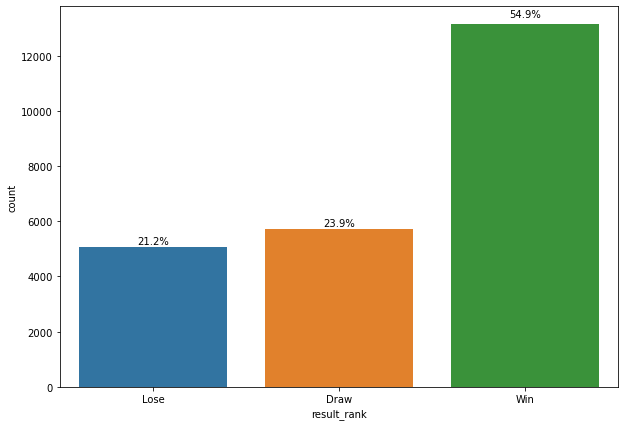

In [21]:
# rank
def rank(team1, team2, team1_rank, team2_rank):
    if team1_rank < team2_rank:
        return team1
    else:
        return team2
    
df['rank'] = df.apply(lambda x: rank(x['home_team'], x['away_team'], x['home_team_fifa_rank'], 
                                     x['away_team_fifa_rank']), axis = 1)

def result_rank(winner, rank):
    if winner == 'Draw':
        return winner
    elif winner == rank:
        return 'Win'
    else:
        return 'Lose'

df['result_rank'] = df.apply(lambda x: result_rank(x['winner'], x['rank']), axis = 1)

plt.figure(figsize = (10, 7))
total = float(len(df))
ax = sns.countplot(x = 'result_rank', data = df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(percentage, (x + width / 2, y + height * 1.02), ha = 'center')

plt.show()

#### Teams wins percentage when teams with high offense score play with teams low offense score

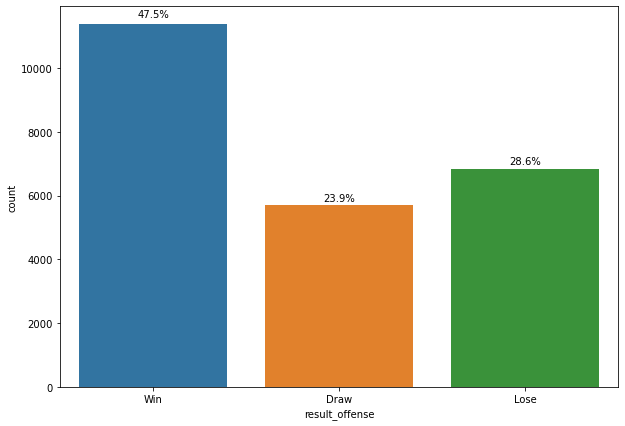

In [22]:
def offense(team1, team2, team1_offense, team2_offense):
    if team1_offense > team2_offense:
        return team1
    else:
        return team2
    
df['offense'] = df.apply(lambda x: offense(x['home_team'], x['away_team'], x['home_team_mean_offense_score'], 
                                     x['away_team_mean_offense_score']), axis = 1)

def result_offense(winner, offense):
    if winner == 'Draw':
        return winner
    elif winner == offense:
        return 'Win'
    else:
        return 'Lose'

df['result_offense'] = df.apply(lambda x: result_offense(x['winner'], x['offense']), axis = 1)

plt.figure(figsize = (10, 7))
total = float(len(df))
ax = sns.countplot(x   = 'result_offense', data = df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(percentage, (x + width / 2, y + height * 1.02), ha = 'center')

plt.show()

#### Teams wins percentage when teams with high defense score play with teams low defense score

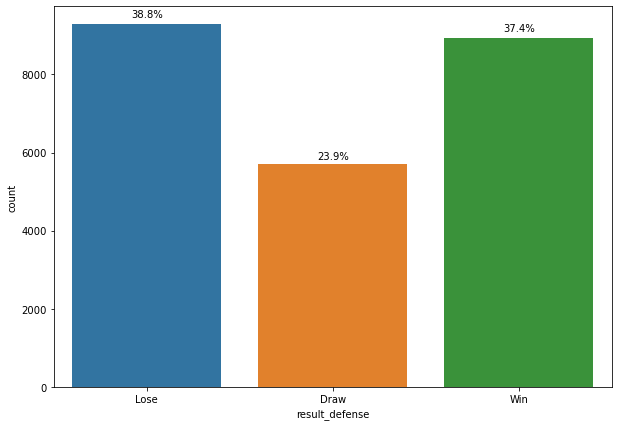

In [23]:
def defense(team1, team2, team1_defense, team2_defense):
    if team1_defense > team2_defense:
        return team1
    else:
        return team2
    
df['defense'] = df.apply(lambda x: defense(x['home_team'], x['away_team'], x['home_team_mean_defense_score'], 
                                     x['away_team_mean_defense_score']), axis = 1)

def result_defense(winner, defense):
    if winner == 'Draw':
        return winner
    elif winner == defense:
        return 'Win'
    else:
        return 'Lose'

df['result_defense'] = df.apply(lambda x: result_defense(x['winner'], x['defense']), axis = 1)

plt.figure(figsize = (10, 7))
total = float(len(df))
ax = sns.countplot(x = 'result_defense', data = df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(percentage, (x + width / 2, y + height * 1.02), ha = 'center')

plt.show()

#### Teams wins percentage when teams with high midfield score play with teams low midfield score

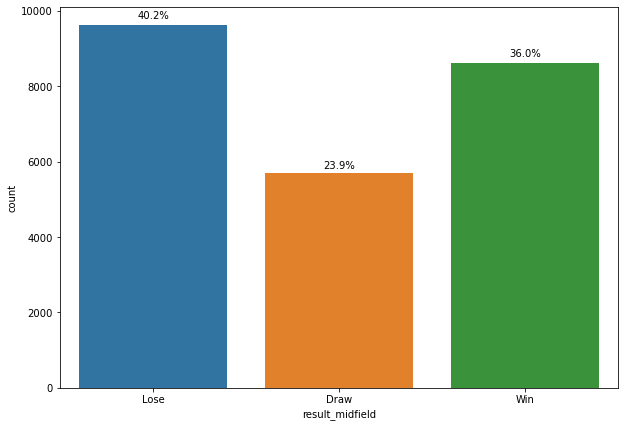

In [24]:
def midfield(team1, team2, team1_midfield, team2_midfield):
    if team1_midfield > team2_midfield:
        return team1
    else:
        return team2
    
df['midfield'] = df.apply(lambda x: midfield(x['home_team'], x['away_team'], x['home_team_mean_midfield_score'], 
                                     x['away_team_mean_midfield_score']), axis = 1)

def result_midfield(winner, midfield):
    if winner == 'Draw':
        return winner
    elif winner == midfield:
        return 'Win'
    else:
        return 'Lose'

df['result_midfield'] = df.apply(lambda x: result_midfield(x['winner'], x['midfield']), axis = 1)

plt.figure(figsize = (10, 7))
total = float(len(df))
ax = sns.countplot(x = 'result_midfield', data = df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(percentage, (x + width / 2, y + height * 1.02), ha = 'center')

plt.show()

#### Teams wins percentage when teams with high goalkeeper score play with teams low goalkeeper score

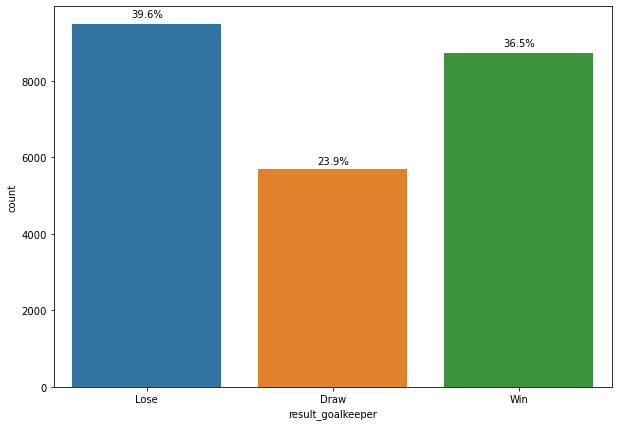

In [25]:
def goalkeeper(team1, team2, team1_goalkeeper, team2_goalkeeper):
    if team1_goalkeeper > team2_goalkeeper:
        return team1
    else:
        return team2
    
df['goalkeeper'] = df.apply(lambda x: goalkeeper(x['home_team'], x['away_team'], x['home_team_goalkeeper_score'], 
                                     x['away_team_goalkeeper_score']), axis = 1)

def result_goalkeeper(winner, goalkeeper):
    if winner == 'Draw':
        return winner
    elif winner == goalkeeper:
        return 'Win'
    else:
        return 'Lose'

df['result_goalkeeper'] = df.apply(lambda x: result_goalkeeper(x['winner'], x['goalkeeper']), axis = 1)

plt.figure(figsize = (10, 7))
total = float(len(df))
ax = sns.countplot(x = 'result_goalkeeper', data = df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(percentage, (x + width / 2, y + height * 1.02), ha = 'center')

plt.show()

#### Teams wins percentage when teams with high total score play with teams low total score

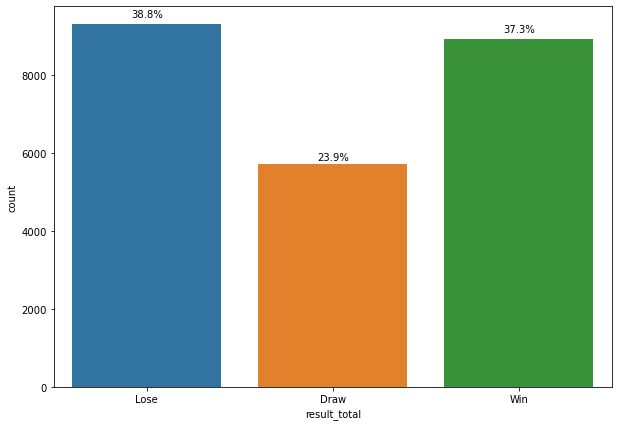

In [26]:
def total(team1, team2, team1_total, team2_total):
    if team1_total > team2_total:
        return team1
    else:
        return team2
    
df['total'] = df.apply(lambda x: total(x['home_team'], x['away_team'], x['total_home_score'], 
                                     x['total_away_score']), axis = 1)

def result_total(winner, total):
    if winner == 'Draw':
        return winner
    elif winner == total:
        return 'Win'
    else:
        return 'Lose'

df['result_total'] = df.apply(lambda x: result_total(x['winner'], x['total']), axis = 1)

plt.figure(figsize = (10, 7))
total = float(len(df))
ax = sns.countplot(x = 'result_total', data = df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(percentage, (x + width / 2, y + height * 1.02), ha = 'center')

plt.show()

### Teams in Qatar 2022 World Cup

#### Offense scores of Qatar 2022 World Cup Teams

In [27]:
offense_score = []
for wc in WC22_teams:
    ofn_score = np.round((df[df['home_team'] == wc]['home_team_mean_offense_score'].mean() + df[df['away_team'] == wc]['away_team_mean_offense_score'].mean())/2, 2)
    offense_score.append(ofn_score)

Offense_score = pd.DataFrame({'Team' : WC22_teams, 'Ofn_score' : offense_score}).sort_values('Ofn_score', ascending = False).reset_index(drop = True)
Offense_score.index += 1
Offense_score

,Team,Ofn_score
1,Argentina,83.51
2,Spain,82.41
3,France,81.91
4,Netherlands,81.88
5,Portugal,81.81
6,England,81.69
7,Brazil,81.68
8,Uruguay,80.55
9,Germany,80.43
10,Belgium,79.48


Text(0.5, 1.0, 'Top 10 offense score')

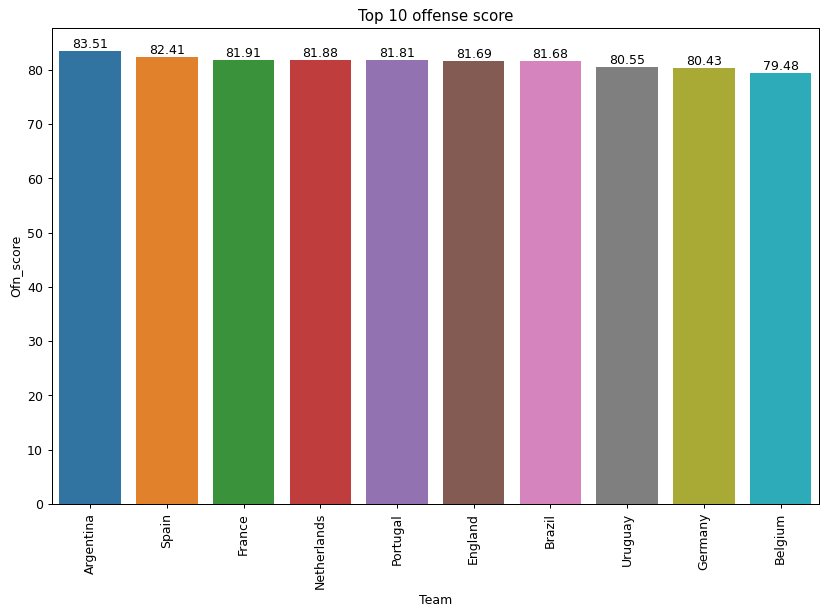

In [28]:
plt.figure(figsize = (11, 7), dpi = 90)
ax = sns.barplot(data = Offense_score[:10], x = 'Team', y = 'Ofn_score')
ax.bar_label(ax.containers[0])
plt.xticks(rotation = 90)
plt.xlabel('Team')
plt.ylabel('Ofn_score')
plt.title('Top 10 offense score')

#### Defence scores of Qatar 2022 World Cup Teams

In [29]:
defense_score = []
for wc in WC22_teams:
    def_score = np.round((df[df['home_team'] == wc]['home_team_mean_defense_score'].mean() + df[df['away_team'] == wc]['away_team_mean_defense_score'].mean())/2, 2)
    defense_score.append(def_score)

Defense_score = pd.DataFrame({'Team' : WC22_teams, 'def_score' : defense_score}).sort_values('def_score', ascending = False).reset_index(drop = True)
Defense_score.index += 1
Defense_score

,Team,def_score
1,Spain,80.64
2,Serbia,80.23
3,England,79.80
4,Germany,79.32
5,Brazil,79.31
6,France,79.19
7,Portugal,78.92
8,Argentina,78.48
9,Belgium,77.54
10,Netherlands,77.17


Text(0.5, 1.0, 'Top 10 defense score')

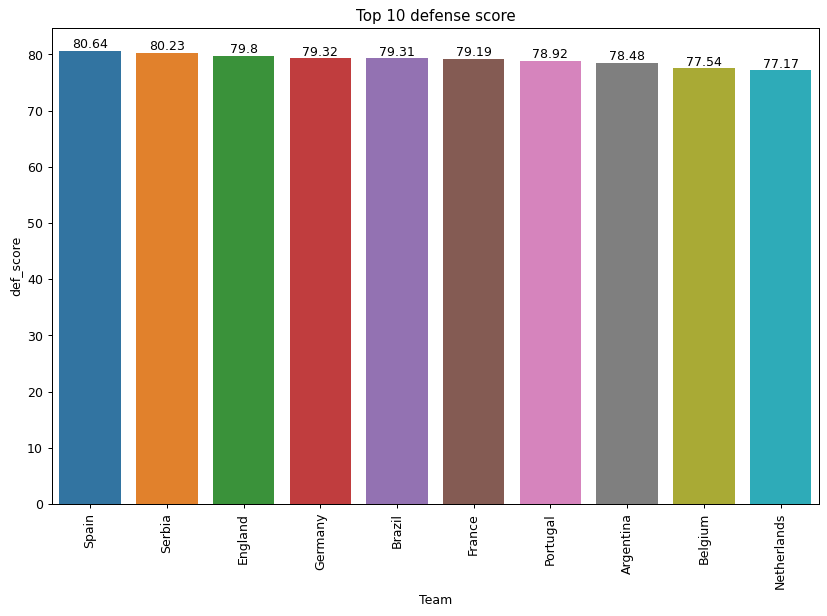

In [30]:
plt.figure(figsize = (11, 7), dpi = 90)
ax = sns.barplot(data = Defense_score[:10], x = 'Team', y = 'def_score')
ax.bar_label(ax.containers[0])
plt.xticks(rotation = 90)
plt.xlabel('Team')
plt.ylabel('def_score')
plt.title('Top 10 defense score')

#### Midfield scores of Qatar 2022 World Cup Teams

In [31]:
midfield_score = []
for wc in WC22_teams:
    mid_score = np.round((df[df['home_team'] == wc]['home_team_mean_midfield_score'].mean() + df[df['away_team'] == wc]['away_team_mean_midfield_score'].mean())/2, 2)
    midfield_score.append(mid_score)

Midfield_score = pd.DataFrame({'Team' : WC22_teams, 'mid_score' : midfield_score}).sort_values('mid_score', ascending = False).reset_index(drop = True)
Midfield_score.index += 1
Midfield_score

,Team,mid_score
1,Spain,83.11
2,France,82.04
3,Germany,81.62
4,England,81.16
5,Argentina,80.94
6,Brazil,80.82
7,Portugal,80.77
8,Netherlands,80.58
9,Serbia,80.31
10,Belgium,79.20


Text(0.5, 1.0, 'Top 10 midfield score')

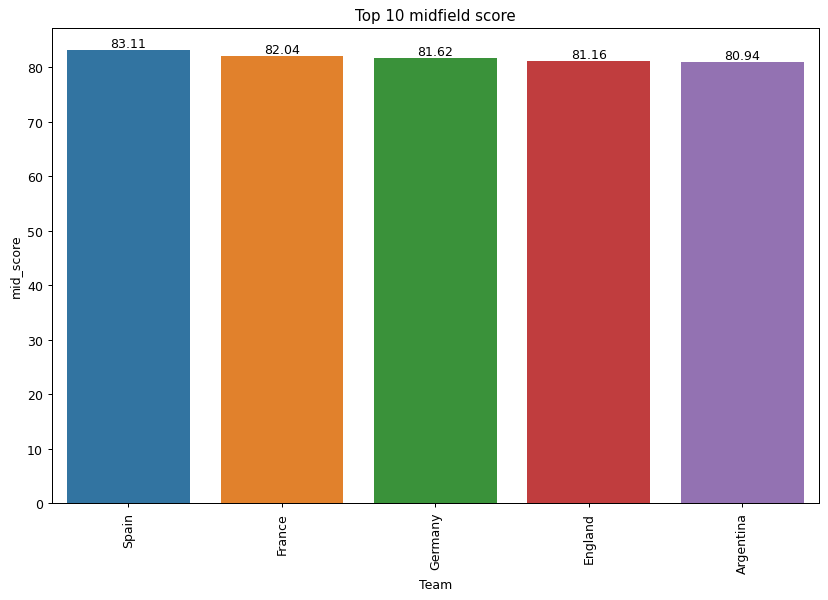

In [32]:
plt.figure(figsize = (11, 7), dpi = 90)
ax = sns.barplot(data = Midfield_score[:5], x = 'Team', y = 'mid_score')
ax.bar_label(ax.containers[0])
plt.xticks(rotation = 90)
plt.xlabel('Team')
plt.ylabel('mid_score')
plt.title('Top 10 midfield score')

#### Goalkeeper scores of Qatar 2022 World Cup Teams

In [33]:
goalkeeper_score = []
for wc in WC22_teams:
    gk_score = np.round((df[df['home_team'] == wc]['home_team_goalkeeper_score'].mean() + df[df['away_team'] == wc]['away_team_goalkeeper_score'].mean())/2, 2)
    goalkeeper_score.append(gk_score)

Goalkeeper_score = pd.DataFrame({'Team' : WC22_teams, 'gk_score' : goalkeeper_score}).sort_values('gk_score', ascending = False).reset_index(drop = True)
Goalkeeper_score.index += 1
Goalkeeper_score

,Team,gk_score
1,Spain,83.06
2,Germany,82.27
3,France,81.20
4,Brazil,79.82
5,England,79.11
6,Netherlands,79.03
7,Belgium,78.55
8,Portugal,78.42
9,Poland,78.18
10,USA,77.35


Text(0.5, 1.0, 'Top 10 goalkeeper score')

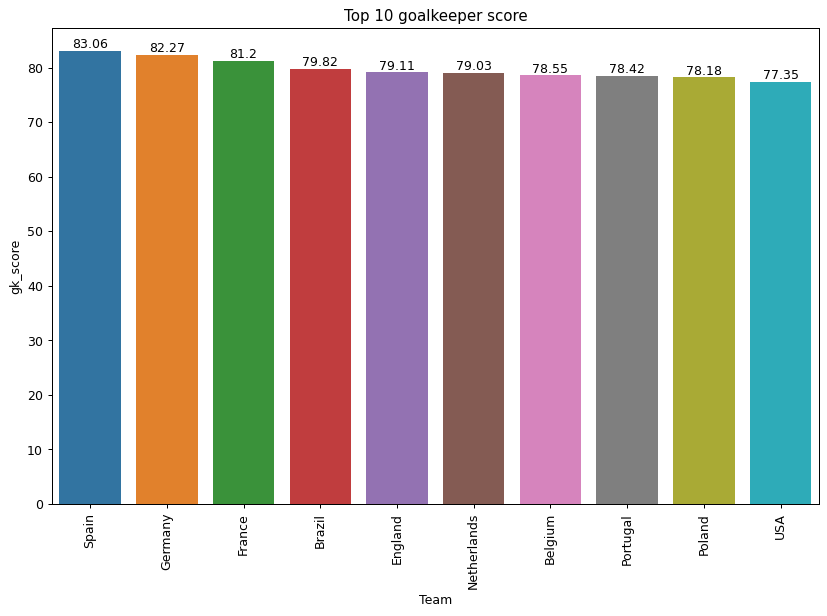

In [34]:
plt.figure(figsize = (11, 7), dpi = 90)
ax = sns.barplot(data = Goalkeeper_score[:10], x = 'Team', y = 'gk_score')
ax.bar_label(ax.containers[0])
plt.xticks(rotation = 90)
plt.xlabel('Team')
plt.ylabel('gk_score')
plt.title('Top 10 goalkeeper score')

#### Teams by Goal difference

In [35]:
goals_conceded_home, goals_scored_home, goals_conceded_away, goals_scored_away = [], [], [], []
total_goals_scored, total_goals_conceded = [], []

for team in WC22_teams:
    gch = df[df['home_team'] == team]['away_team_score'].sum()
    gsh = df[df['home_team'] == team]['home_team_score'].sum()
    gca = df[df['away_team'] == team]['home_team_score'].sum()
    gsa = df[df['away_team'] == team]['away_team_score'].sum()
    
    tgc = np.add(gch, gca)
    tgs = np.add(gsh, gsa)
    
    goals_conceded_home.append(gch)
    goals_scored_home.append(gsh)    
    goals_conceded_away.append(gca)    
    goals_scored_away.append(gsa)    
    
    total_goals_scored.append(tgs)
    total_goals_conceded.append(tgc)
    
goals = pd.DataFrame({'Team' : WC22_teams, 'Scored_goals_home' : goals_scored_home, 'Scored_goals_away' : goals_scored_away,
                     'Conceded_goals_home' : goals_conceded_home, 'Conceded_goals_away' : goals_conceded_away,
                     'Total_scored_goals' : total_goals_scored, 'Total_conceded_goals' : total_goals_conceded,})

goals['Goal_difference'] = goals['Total_scored_goals'] - goals['Total_conceded_goals']
goals['Goal_ratio'] = goals['Total_scored_goals'] / goals['Total_conceded_goals']

goals = goals.sort_values('Goal_difference', ascending = False).reset_index(drop = True)
goals.index += 1
goals

,Team,Scored_goals_home,Scored_goals_away,Conceded_goals_home,Conceded_goals_away,Total_scored_goals,Total_conceded_goals,Goal_difference,Goal_ratio
1,Brazil,558,396,141,159,954,300,654,3.180000
2,Spain,469,312,107,141,781,248,533,3.149194
3,Germany,544,331,220,171,875,391,484,2.237852
4,Netherlands,426,274,145,142,700,287,413,2.439024
5,France,447,223,154,112,670,266,404,2.518797
6,Portugal,424,244,124,144,668,268,400,2.492537
7,England,384,246,132,119,630,251,379,2.509960
8,Japan,533,243,273,153,776,426,350,1.821596
9,Mexico,572,286,272,247,858,519,339,1.653179
10,Australia,435,194,127,164,629,291,338,2.161512


#### How offense score of teams affect the goals scored

In [36]:
off_vs_goals_scored = Offense_score.merge(goals, on = 'Team')[['Team', 'Ofn_score', 'Total_scored_goals']]
off_vs_goals_scored['Total_scored_goals/ofn_score'] = off_vs_goals_scored['Total_scored_goals'] / off_vs_goals_scored['Ofn_score']
off_vs_goals_scored = off_vs_goals_scored.sort_values('Total_scored_goals/ofn_score', ascending = False).reset_index(drop = True)
off_vs_goals_scored.index += 1
off_vs_goals_scored

,Team,Ofn_score,Total_scored_goals,Total_scored_goals/ofn_score
1,Brazil,81.68,954,11.679726
2,Mexico,77.68,858,11.045314
3,Germany,80.43,875,10.879025
4,Japan,73.87,776,10.504941
5,Saudi Arabia,74.09,762,10.284789
6,USA,75.77,761,10.043553
7,Spain,82.41,781,9.477005
8,Korea Republic,75.19,685,9.110254
9,Netherlands,81.88,700,8.549096
10,Australia,74.72,629,8.418094


Text(0.5, 1.0, 'Top 10 best team ratio goals/offense score')

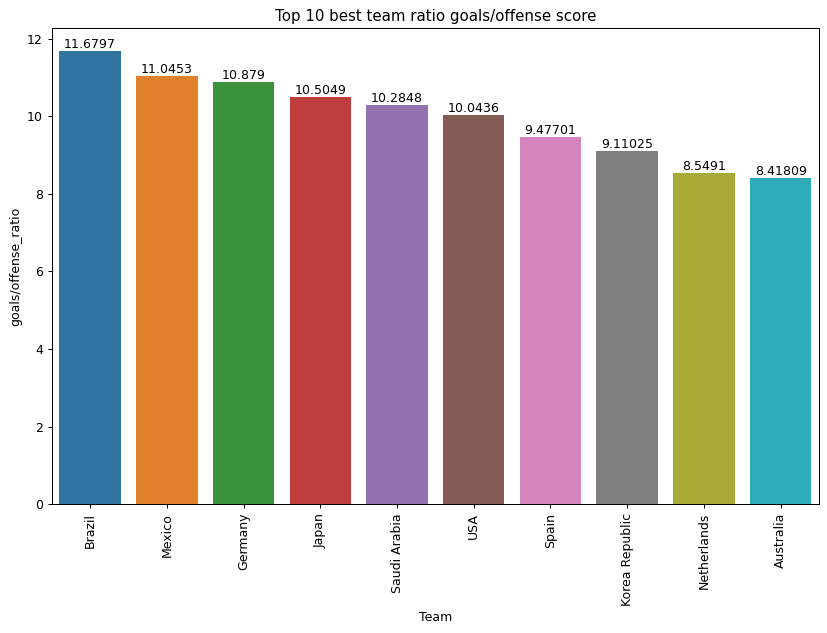

In [37]:
plt.figure(figsize = (11, 7), dpi = 90)
ax = sns.barplot(data = off_vs_goals_scored[:10], x = 'Team', y = 'Total_scored_goals/ofn_score')
ax.bar_label(ax.containers[0])
plt.xticks(rotation = 90)
plt.xlabel('Team')
plt.ylabel('goals/offense_ratio')
plt.title('Top 10 best team ratio goals/offense score')

#### How goalkeeper score of teams affect the goals conceded

In [38]:
gk_vs_goals_conceded = Goalkeeper_score.merge(goals, on = 'Team')[['Team', 'gk_score', 'Total_conceded_goals']]
gk_vs_goals_conceded['Total_conceded_goals/gk_score'] = gk_vs_goals_conceded['Total_conceded_goals'] / gk_vs_goals_conceded['gk_score']
gk_vs_goals_conceded = gk_vs_goals_conceded.sort_values('Total_conceded_goals/gk_score', ascending = True).reset_index(drop = True)
gk_vs_goals_conceded.index += 1
gk_vs_goals_conceded

,Team,gk_score,Total_conceded_goals,Total_conceded_goals/gk_score
1,Serbia,76.48,193,2.523536
2,Spain,83.06,248,2.985793
3,England,79.11,251,3.172797
4,France,81.20,266,3.275862
5,Morocco,71.79,240,3.343084
6,Portugal,78.42,268,3.417496
7,Netherlands,79.03,287,3.631532
8,Brazil,79.82,300,3.758457
9,Australia,76.03,291,3.827437
10,Canada,71.77,276,3.845618


Text(0.5, 1.0, 'Top 10 best team ratio gk/conceded score')

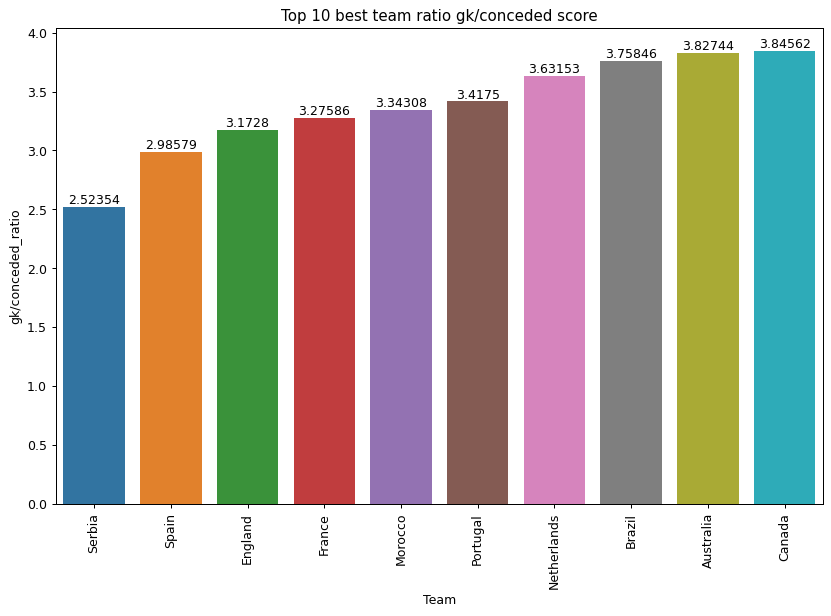

In [39]:
plt.figure(figsize = (11, 7), dpi = 90)
ax = sns.barplot(data = gk_vs_goals_conceded[:10], x = 'Team', y = 'Total_conceded_goals/gk_score')
ax.bar_label(ax.containers[0])
plt.xticks(rotation = 90)
plt.xlabel('Team')
plt.ylabel('gk/conceded_ratio')
plt.title('Top 10 best team ratio gk/conceded score')

#### Top 10 Teams With The Longest Win Streak

In [40]:
dframes = {}
for team in WC22_teams:
    df1 = df[(df['home_team'] == team) | (df['away_team'] == team)]
    df1['wins'] = np.where(((df1['home_team'] == team) & (df1['home_team_result'] == 'Win')) | ((df1['away_team'] == team) & (df1['home_team_result'] == 'Lose')), 1, 0)
    
    name = team + '_streak'
    dframes[name] = df1
    
streaks = []
for frame in dframes.keys():
    dframes[frame]['start_of_streak'] = dframes[frame]['wins'].ne(dframes[frame]['wins'].shift())
    dframes[frame]['streaks_id'] = dframes[frame]['start_of_streak'].cumsum()
    dframes[frame]['streak_counter'] = dframes[frame].groupby('streaks_id').cumcount() + 1
    
    streak = dframes[frame][dframes[frame]['wins'] == 1]['streak_counter'].max()
    streaks.append(streak)
    
Streaks = pd.DataFrame({'Team' : WC22_teams, 'Streak' : streaks}).sort_values('Streak', ascending = False).reset_index(drop = True)
Streaks.index += 1
Streaks.head(10)

,Team,Streak
1,Spain,25.0
2,France,14.0
3,Brazil,14.0
4,Australia,13.0
5,Belgium,12.0
6,Morocco,12.0
7,Saudi Arabia,11.0
8,USA,11.0
9,Mexico,10.0
10,Switzerland,10.0


Text(0.5, 1.0, 'Top 10 best team with longest win streak')

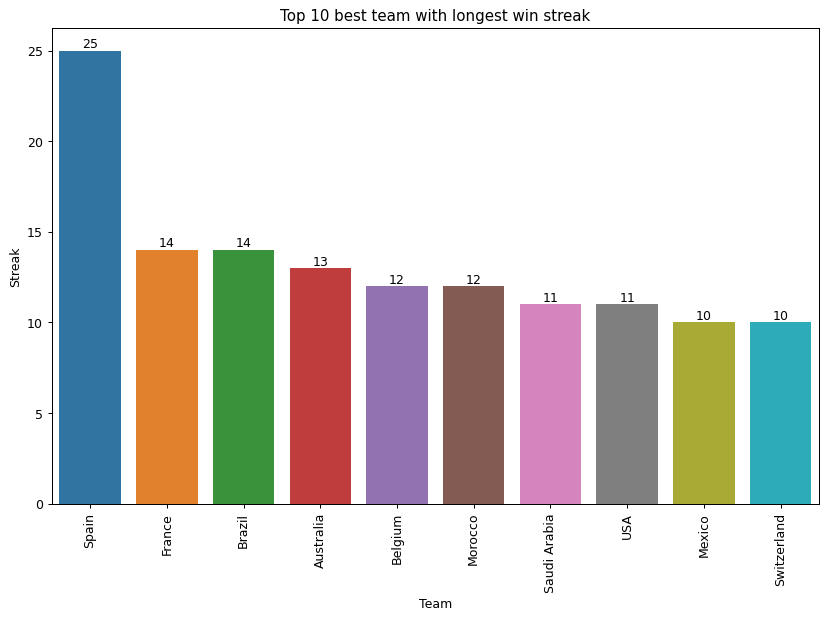

In [41]:
plt.figure(figsize = (11, 7), dpi = 90)
ax = sns.barplot(data = Streaks[:10], x = 'Team', y = 'Streak')
ax.bar_label(ax.containers[0])
plt.xticks(rotation = 90)
plt.xlabel('Team')
plt.ylabel('Streak')
plt.title('Top 10 best team with longest win streak')

#### Away team win percentage

In [42]:
away_team_better_rank = df[(df['home_team_fifa_rank'] > df['away_team_fifa_rank'])]['home_team_result'].value_counts()
away_team_better_rank

Lose    4984
Win     3429
Draw    2840
Name: home_team_result, dtype: int64

#### Home team win percentage

In [43]:
home_team_better_rank = df[(df['home_team_fifa_rank'] < df['away_team_fifa_rank'])]['home_team_result'].value_counts()
home_team_better_rank

Win     8313
Draw    2542
Lose    1781
Name: home_team_result, dtype: int64

#### Top 10 Teams by Rank

In [44]:
# ranking = df[['date', 'home_team', 'away_team', 'home_team_fifa_rank', 'away_team_fifa_rank']]
# ranks = []
# for x in WC22_teams:
#     rank_df = ranking[(ranking['home_team'] == x) | (ranking['away_team'] == x)].sort_values(['date', 'home_team_fifa_rank', 'away_team_fifa_rank'],ascending = [False, False, False])
#     if rank_df['home_team' == x:
#         rank = rank_df['home_team_fifa_rank']
#     else:
#         rank = rank_df['away_team_fifa_rank']
#     ranks.append(rank)
    
# team_ranks = pd.DataFrame({'Team' : WC22_teams, 'Rank' : ranks}).sort_values('Rank').reset_index(drop =True)
# team_ranks.index += 1
# team_ranks

#### Top teams with a high win percentage

In [45]:
hwins, hdraws, hloses = [], [], []
awins, adraws, aloses = [], [], []
for team in WC22_teams:
    home_win = df[df['home_team'] == team][df['home_team_result'] == 'Win'].shape[0]
    home_draw = df[df['home_team'] == team][df['home_team_result'] == 'Draw'].shape[0]    
    home_lose = df[df['home_team'] == team][df['home_team_result'] == 'Lose'].shape[0]    
    
    away_win = df[df['away_team'] == team][df['home_team_result'] == 'Win'].shape[0]    
    away_draw = df[df['away_team'] == team][df['home_team_result'] == 'Draw'].shape[0]    
    away_lose = df[df['away_team'] == team][df['home_team_result'] == 'Lose'].shape[0]
    
    hwins.append(home_win)
    hdraws.append(home_draw)
    hloses.append(home_lose)
    
    awins.append(away_win)
    adraws.append(away_draw)
    aloses.append(away_lose)
    
    wins = np.add(hwins, awins)
    draws = np.add(hdraws, adraws)    
    loses = np.add(hloses, aloses)

In [46]:
win_draw_lose = pd.DataFrame({'Team' : WC22_teams, 'Win' : wins, 'Draw' : draws, 'Lose' : loses,
                              'Home_win' : hwins, 'Home_draw' : hdraws, 'Home_lose' : hloses,
                              'Away_win' : awins, 'Away_draw' : adraws, 'Away_lose' : aloses})

win_draw_lose.insert(1, 'Total', win_draw_lose['Win'] + win_draw_lose['Draw'] + win_draw_lose['Lose'])
win_draw_lose.insert(8, 'Total_Home', win_draw_lose['Home_win'] + win_draw_lose['Home_draw'] + win_draw_lose['Home_lose'])
win_draw_lose.insert(12, 'Total_Away', win_draw_lose['Away_win'] + win_draw_lose['Away_draw'] + win_draw_lose['Away_lose'])

win_draw_lose['Win %'] = np.round(100 * win_draw_lose['Win'] / win_draw_lose['Total'], 2)
win_draw_lose['Draw %'] = np.round(100 * win_draw_lose['Draw'] / win_draw_lose['Total'], 2)
win_draw_lose['Lose %'] = np.round(100 * win_draw_lose['Lose'] / win_draw_lose['Total'], 2)

win_draw_lose['Home_Win %'] = np.round(100 * win_draw_lose['Home_win'] / win_draw_lose['Total_Home'], 2)
win_draw_lose['Home_Draw %'] = np.round(100 * win_draw_lose['Home_draw'] / win_draw_lose['Total_Home'], 2)
win_draw_lose['Home_Lose %'] = np.round(100 * win_draw_lose['Home_lose'] / win_draw_lose['Total_Home'], 2)

win_draw_lose['Away_Win %'] = np.round(100 * win_draw_lose['Away_win'] / win_draw_lose['Total_Away'], 2)
win_draw_lose['Away_Draw %'] = np.round(100 * win_draw_lose['Away_draw'] / win_draw_lose['Total_Away'], 2)
win_draw_lose['Away_Lose %'] = np.round(100 * win_draw_lose['Away_lose'] / win_draw_lose['Total_Away'], 2)

# win_draw_lose.style.set_properties(**{'background-color' : 'green', 'color' : 'white'}, subset = ['Home_win', 'Home_Win %', 'Win %'])
win_draw_lose = win_draw_lose.sort_values(['Win %', 'Home_Win %', 'Home_win'], ascending = [False, False, False])
win_draw_lose = win_draw_lose.reset_index(drop = True)
win_draw_lose.index += 1

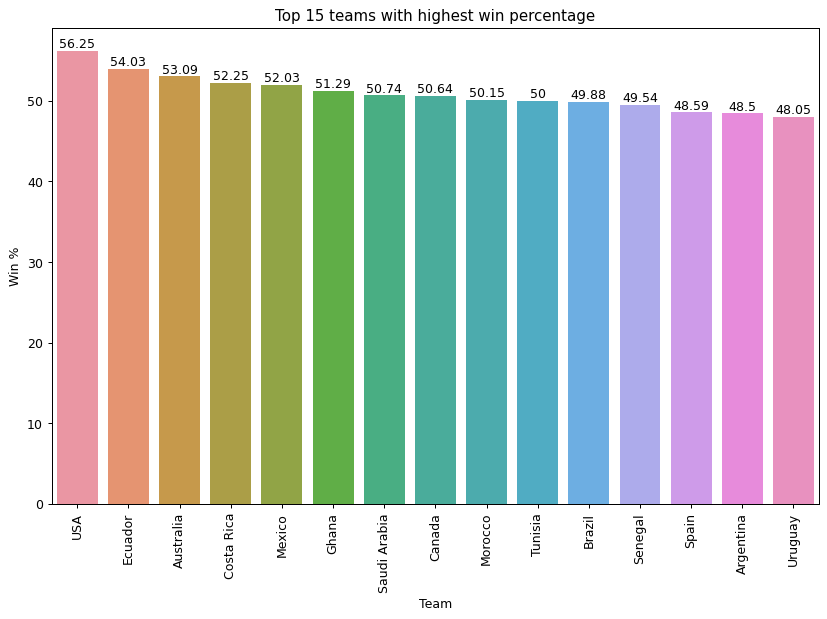

In [47]:
plt.figure(figsize = (11, 7), dpi = 90)
ax = sns.barplot(data = win_draw_lose[:15], x = 'Team', y = 'Win %')
ax.bar_label(ax.containers[0])
plt.xticks(rotation = 90)
plt.xlabel('Team')
plt.ylabel('Win %')
plt.title('Top 15 teams with highest win percentage')
plt.show()

In [48]:
df.isna().sum()

date                             0
home_team                        0
away_team                        0
home_team_continent              0
away_team_continent              0
home_team_fifa_rank              0
away_team_fifa_rank              0
home_team_total_fifa_points      0
away_team_total_fifa_points      0
home_team_score                  0
away_team_score                  0
tournament                       0
city                             0
country                          0
neutral_location                 0
shoot_out                        0
home_team_result                 0
home_team_goalkeeper_score       0
away_team_goalkeeper_score       0
home_team_mean_defense_score     0
home_team_mean_offense_score     0
home_team_mean_midfield_score    0
away_team_mean_defense_score     0
away_team_mean_offense_score     0
away_team_mean_midfield_score    0
total_home_score                 0
total_away_score                 0
winner                           0
rank                

## Feature Engineering

In [49]:
df['rank_difference'] = df['home_team_fifa_rank'] - df['away_team_fifa_rank']
df['average_rank'] = (df['home_team_fifa_rank'] + df['away_team_fifa_rank'])/2
df['point_difference'] = df['home_team_total_fifa_points'] - df['away_team_total_fifa_points']
df['score_difference'] = df['home_team_score'] - df['away_team_score']
df['is_won'] = np.where(df['score_difference'] > 0, 1, 0) # take draw as lost
df['is_stake'] = df['tournament'] != 'Friendly'

## Model

### Data

In [50]:
# Pre_processing continued

sc = StandardScaler()

X = df[['is_won', 'average_rank', 'rank_difference', 'point_difference']]
for i in X.columns.difference(['is_won']):
    X[i] = sc.fit_transform(X[i].values.reshape(-1, 1))

In [51]:
role = get_execution_role()
sess = Session()
region = boto3.Session().region_name
bucket_name = 'sm-qwc22'
prefix = 'classifier_qwc22_wnr'

In [52]:
train_data, validation_data, test_data = np.split(X.sample(frac = 1, random_state = 123),
                                                 [int(0.8 * len(X)), int(0.95 * len(X))])
train_data.shape, validation_data.shape, test_data.shape

((19136, 4), (3588, 4), (1197, 4))

In [53]:
train_data.to_csv('train_data.csv', index = False, header = False)
boto3.Session().resource("s3").Bucket(bucket_name).Object(os.path.join(prefix, "train", 'train_data.csv')).upload_file('train_data.csv')
s3_input_train = TrainingInput('s3://{0}/{1}/train'.format(bucket_name, prefix), content_type = 'csv')

In [54]:
validation_data.to_csv('validation_data.csv', index = False, header = False)
boto3.Session().resource("s3").Bucket(bucket_name).Object(os.path.join(prefix, "validation", 'validation_data.csv')).upload_file('validation_data.csv')
s3_input_validation = TrainingInput('s3://{0}/{1}/validation'.format(bucket_name, prefix), content_type = 'csv')

In [55]:
test_data.to_csv('test_data.csv', index = False, header = False)
boto3.Session().resource("s3").Bucket(bucket_name).Object(os.path.join(prefix, "test", 'test_data.csv')).upload_file('test_data.csv')
s3_input_test = TrainingInput('s3://{0}/{1}/test'.format(bucket_name, prefix), content_type = 'csv')

In [56]:
s3_model_output_location = r's3://{0}/model'.format(bucket_name)

In [57]:
# !aws s3 ls {bucket_name}/{prefix}/train --recursive
# !aws s3 ls {bucket_name}/{prefix}/validation --recursive
# !aws s3 ls {bucket_name}/{prefix}/test --recursive

### Training

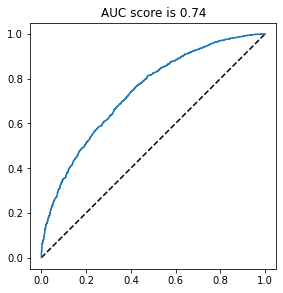

In [58]:
!pip install xgboost -q
from xgboost import XGBClassifier

x, y = X.loc[:,['average_rank', 'rank_difference', 'point_difference']], X['is_won']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.15, random_state = 1)

model = XGBClassifier()
model = model.fit(X_train, y_train)

# figures 
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
ax.set_aspect(1)

In [59]:
# from sagemaker import image_uris, model_uris, script_uris

# train_model_id, train_model_version, train_scope = "catboost-classification-model", "*", "training"
# training_instance_type = "ml.m4.xlarge"

# # Retrieve the docker image
# train_image_uri = image_uris.retrieve(
#     region=None,
#     framework=None,
#     model_id=train_model_id,
#     model_version=train_model_version,
#     image_scope=train_scope,
#     instance_type=training_instance_type
# )

# # Retrieve the training script
# train_source_uri = script_uris.retrieve(
#     model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
# )

# train_model_uri = model_uris.retrieve(
#     model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
# )

# from sagemaker import hyperparameters

# # Retrieve the default hyper-parameters for training the model
# hyperparameters = hyperparameters.retrieve_default(
#     model_id=train_model_id, model_version=train_model_version
# )

# # [Optional] Override default hyperparameters with custom values
# hyperparameters["iterations"] = "5000"
# hyperparameters["num_leaves"] = "42"
# hyperparameters["learning_rate"] = "0.07"
# hyperparameters["eval_metric"] = "AUC"

# print(hyperparameters)

# from sagemaker.estimator import Estimator
# from sagemaker.utils import name_from_base

# training_job_name = name_from_base(f"built-in-algo-{train_model_id}-training")

# # Create SageMaker Estimator instance
# tabular_estimator = Estimator(
#     role=role,
#     image_uri=train_image_uri,
#     source_dir=train_source_uri,
#     model_uri=train_model_uri,
#     entry_point="transfer_learning.py",
#     instance_count=1,
#     instance_type=training_instance_type,
#     max_run=360000,
#     hyperparameters=hyperparameters,
#     output_path=s3_model_output_location
# )

# # Launch a SageMaker Training job by passing the S3 path of the training data
# tabular_estimator.fit(
#     {"training": s3_input_train, "validation" : s3_input_validation}, logs=True, job_name=training_job_name
# )

In [60]:
container = sagemaker.image_uris.retrieve('xgboost', region, version = 'latest')

classifier = sagemaker.estimator.Estimator(image_uri = container,
                                          role = role,
                                          instance_count = 1, 
                                          instance_type = 'ml.m5.xlarge', 
                                          volume_size = 5, 
                                          output_path = s3_model_output_location,
                                          sagemaker_session = sess,
                                          rules = [Rule.sagemaker(rule_configs.overfit())])

classifier.set_hyperparameters(objective = 'binary:logistic', 
                               num_round = 1000,
                               eta = 0.1,
                               gamma= 4)

classifier.fit({'train' : s3_input_train, 'validation' : s3_input_validation}, wait = True)

classifier.model_data

INFO:sagemaker:Creating training-job with name: xgboost-2023-01-03-00-34-36-095


2023-01-03 00:34:36 Starting - Starting the training job...
2023-01-03 00:35:00 Starting - Preparing the instances for trainingOverfit: InProgress
.........
2023-01-03 00:36:28 Downloading - Downloading input data...
2023-01-03 00:37:01 Training - Training image download completed. Training in progress.
2023-01-03 00:37:01 Uploading - Uploading generated training modelArguments: train
[2023-01-03:00:36:46:INFO] Running standalone xgboost training.
[2023-01-03:00:36:46:INFO] File size need to be processed in the node: 1.34mb. Available memory size in the node: 8381.74mb
[2023-01-03:00:36:46:INFO] Determined delimiter of CSV input is ','
[00:36:46] S3DistributionType set as FullyReplicated
[00:36:46] 19136x3 matrix with 57408 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2023-01-03:00:36:46:INFO] Determined delimiter of CSV input is ','
[00:36:46] S3DistributionType set as FullyReplicated
[00:36:46] 3588x3 matrix with 10764 entries loaded from /opt/m

's3://sm-qwc22/model/xgboost-2023-01-03-00-34-36-095/output/model.tar.gz'

### Deployment

In [61]:
predictor = classifier.deploy(initial_instance_count = 1,
                              instance_type = 'ml.t2.large',
                              serializer = CSVSerializer())

predictor.endpoint_name

INFO:sagemaker:Creating model with name: xgboost-2023-01-03-00-37-48-606
INFO:sagemaker:Creating endpoint-config with name xgboost-2023-01-03-00-37-48-606
INFO:sagemaker:Creating endpoint with name xgboost-2023-01-03-00-37-48-606


------!

'xgboost-2023-01-03-00-37-48-606'

### Prediction

In [62]:
def predict(data, rows = 1000):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, predictor.predict(array).decode('utf-8')])
    return np.fromstring(predictions[1:], sep = ',')

predictions = predict(test_data.to_numpy()[:, 1:])
predictions

array([0.31534263, 0.70124626, 0.54398751, ..., 0.79568082, 0.21511161,
       0.53046119])

### Evaluation

In [63]:
print(classification_report(test_data.iloc[:, 0], np.where(predictions > 0.5, 1, 0)))

              precision    recall  f1-score   support

           0       0.65      0.73      0.69       596
           1       0.70      0.62      0.65       601

    accuracy                           0.67      1197
   macro avg       0.67      0.67      0.67      1197
weighted avg       0.67      0.67      0.67      1197



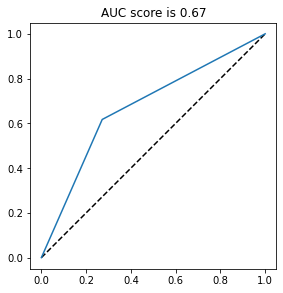

In [64]:
# Roc_Auc_Curve
fpr, tpr, _ = roc_curve(test_data.iloc[:, 0], np.where(predictions > 0.5, 1, 0))
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(test_data.iloc[:, 0], np.where(predictions > 0.5, 1, 0))))
ax.set_aspect(1)

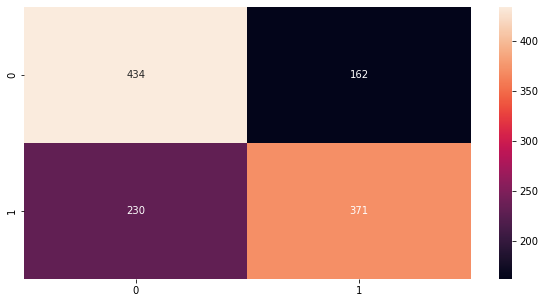

In [65]:
# Confusion_Matrix
plt.figure(figsize=(10, 5))
cm = confusion_matrix(test_data.iloc[:, 0], np.where(predictions > 0.5, 1, 0))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

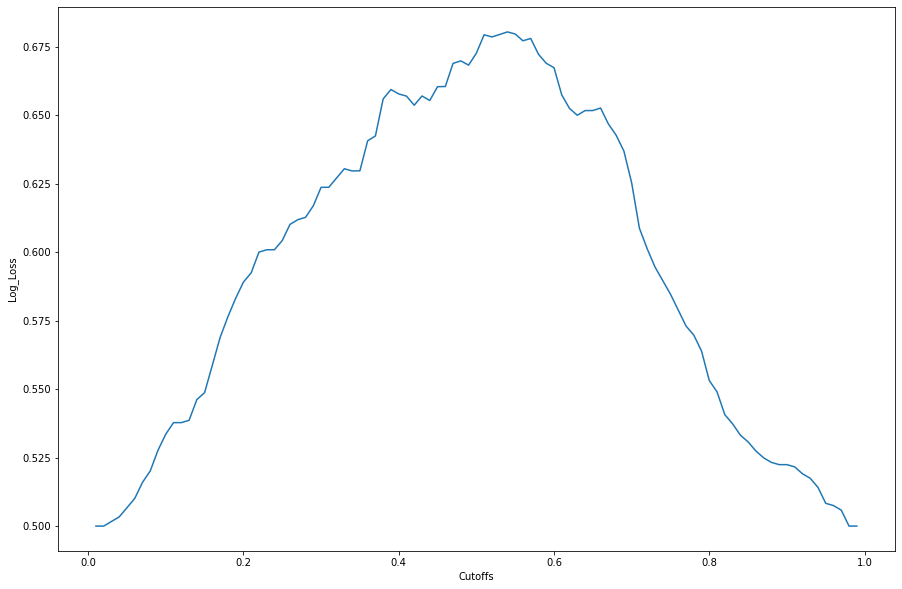

In [66]:
cutoffs = np.arange(0.01, 1, 0.01)
auc = []
for c in cutoffs:
    auc.append(roc_auc_score(test_data.iloc[:, 0], np.where(predictions > c, 1, 0)))

plt.figure(figsize = (15, 10))
plt.plot(cutoffs, auc)
plt.xlabel('Cutoffs')
plt.ylabel('Log_Loss')
plt.show()

In [67]:
print('AUC is minimized at a cufoff of ', cutoffs[np.argmax(auc)], ', and the AUC value at the maximum is ', np.max(auc))

AUC is minimized at a cufoff of  0.54 , and the AUC value at the maximum is  0.6805268623881897


## Testing | World Cup Winner Prediction

#### World Cup Rankings Home

In [68]:
world_cup_rankings_home = df[['home_team','home_team_fifa_rank','home_team_total_fifa_points', 'is_won']].loc[df['home_team'].isin(WC22_teams) & (df['date'] >= '2018-01-01')] #Get last 2 years of information (try to get all time too, get interesting results!)
world_cup_rankings_away = df[['away_team','away_team_fifa_rank','away_team_total_fifa_points', 'is_won']].loc[df['away_team'].isin(WC22_teams)& (df['date'] >= '2018-01-01')]
world_cup_rankings_home = world_cup_rankings_home.set_index(['home_team'])

In [69]:
#The idea is to separete the performance of each Team as Home or Away.
world_cup_rankings_home = world_cup_rankings_home.groupby('home_team').mean()
world_cup_rankings_away = world_cup_rankings_away.groupby('away_team').mean()

In [70]:
world_cup_rankings_home.head(13)

,home_team_fifa_rank,home_team_total_fifa_points,is_won
home_team,,,
Argentina,8.312500,1602.468750,0.593750
Australia,39.111111,1376.333333,0.555556
Belgium,1.727273,1713.939394,0.787879
Brazil,2.810811,1731.324324,0.675676
Cameroon,50.956522,1353.695652,0.478261
Canada,62.470588,1323.588235,0.882353
Costa Rica,42.272727,1393.318182,0.500000
Croatia,11.517241,1580.482759,0.551724
Denmark,11.677419,1511.870968,0.645161


In [71]:
world_cup_rankings_away.head(13)

,away_team_fifa_rank,away_team_total_fifa_points,is_won
away_team,,,
Argentina,7.545455,1588.454545,0.136364
Australia,38.947368,1263.526316,0.315789
Belgium,1.560000,1787.240000,0.160000
Brazil,2.250000,1680.600000,0.000000
Cameroon,49.789474,1301.315789,0.315789
Canada,62.695652,1371.956522,0.347826
Costa Rica,38.911765,1347.823529,0.500000
Croatia,11.642857,1562.642857,0.392857
Denmark,11.500000,1588.230769,0.192308


In [72]:
world_cup_rankings_home.index

Index(['Argentina', 'Australia', 'Belgium', 'Brazil', 'Cameroon', 'Canada',
       'Costa Rica', 'Croatia', 'Denmark', 'Ecuador', 'England', 'France',
       'Germany', 'Ghana', 'Japan', 'Korea Republic', 'Mexico', 'Morocco',
       'Netherlands', 'Poland', 'Portugal', 'Qatar', 'Saudi Arabia', 'Senegal',
       'Serbia', 'Spain', 'Switzerland', 'Tunisia', 'USA', 'Uruguay', 'Wales'],
      dtype='object', name='home_team')

### Creating Qatar World Cup Simulation

In [73]:
from tqdm import tqdm #SHOW TASK BAR

simulation_winners = list()
simulation_results_winners = list()
simulation_results_round16 = list()
simulation_df_round16 = list()
simulation_results_quarterfinal = list()
simulation_df_quarterfinal = list()
simulation_results_semifinal = list()
simulation_df_semifinal = list()

n_simulations = 1000 #Number of Simulations

for j in tqdm(range(n_simulations)):
    #IMPORTANT: It has to sort the teams in the order of pairs they might go against starting from round_16 (i.e SENEGAL X NETHERLANDS, or FRANCE x DENMARK) - to play around with the matches check https://www.telegraph.co.uk/world-cup/2022-predictor-wallchart-football-qatar/
    #Before the world cup, this first list was my personal opnion which teams would advance to the round_16. Belgium and Germany wore my biggest surprise!
    #candidates = [ 'Senegal', 'Netherlands', 'England','USA', 'Argentina', 'Poland', 'France', 'Denmark','Spain', 'Germany', 'Belgium', 'Croatia', 'Brazil', 'Serbia', 'Portugal','Uruguay']
    #New Update: Official teams that advanced to the round_16 world cup 22! 
    candidates = ['Senegal', 'England', 'Netherlands', 'USA', 
                  'Argentina', 'Australia', 'France', 'Poland', 
                  'Spain', 'Morocco', 'Japan', 'Croatia', 
                  'Brazil', 'Serbia', 'Portugal', 'Switzerland']
    finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']
    
    for f in finals:
        iterations = int(len(candidates) / 2)
        #print('STEP:', iterations) #uncomment to observe in more details the iteraction
        winners = []
        prob = []


        for i in range(iterations):
            home = candidates[i*2]
            away = candidates[i*2+1]
            
            row = pd.DataFrame(np.array([[True, np.nan, np.nan, np.nan]]), columns = X.columns)
            is_won = world_cup_rankings_home.loc[home, 'is_won']
            home_rank = world_cup_rankings_home.loc[home, 'home_team_fifa_rank']
            home_points = world_cup_rankings_home.loc[home, 'home_team_total_fifa_points']
            opp_rank = world_cup_rankings_away.loc[away, 'away_team_fifa_rank']
            opp_points = world_cup_rankings_away.loc[away, 'away_team_total_fifa_points']
            row['is_won'] = is_won
            row['average_rank'] = (home_rank + opp_rank) / 2
            row['rank_difference'] = home_rank - opp_rank
            row['point_difference'] = home_points - opp_points
            home_win_prob = predict(row.to_numpy()[:, 1:])
            
            
            # simulation step based on the probability
            simulated_outcome = np.random.binomial(1, home_win_prob)
            winners.append(away) if simulated_outcome <= 0.5 else winners.append(home)
            prob.append(1 - simulated_outcome) if simulated_outcome <= 0.5 else prob.append(simulated_outcome)
        
        if f == 'round_of_16':
            step_16 = ['round_16'] * 8
            candidates_round_16 = zip(step_16, winners, prob)
            df_candidates_round_16 = pd.DataFrame(candidates_round_16, columns = ['Step','Team','Prob'])
            simulation_df_round16.append(df_candidates_round_16)
            simulation_results_round16.append(winners)

        if f == 'quarterfinal':
            step_quarterfinal = ['quarterfinal'] * 4
            candidates_quarterfinal = zip(step_quarterfinal,winners, prob)
            df_candidates_quarterfinal = pd.DataFrame(candidates_quarterfinal, columns = ['Step','Team','Prob'])
            simulation_df_quarterfinal.append(df_candidates_quarterfinal)
            simulation_results_quarterfinal.append(winners)

        if f == 'semifinal':    
            step_semifinal = ['semifinal'] * 2
            candidates_semifinal = zip(step_semifinal,winners, prob)
            df_candidates_semifinal = pd.DataFrame(candidates_semifinal, columns = ['Step','Team','Prob'])
            simulation_df_semifinal.append(df_candidates_semifinal)
            simulation_results_semifinal.append(winners)

        if f == 'final':    
            step_final = ['final'] * 1
            candidates_final = zip(step_final,winners, prob)
            df_candidates_final = pd.DataFrame(candidates_final, columns = ['Step','Team','Prob'])
            simulation_winners.append(df_candidates_final)
            simulation_results_winners.append(winners)
            
        candidates = winners 

df_candidates_round_16 = pd.concat(simulation_df_round16)
df_candidates_quarterfinal = pd.concat(simulation_df_quarterfinal)
df_candidates_semifinal = pd.concat(simulation_df_semifinal)
df_candidates_final = pd.concat(simulation_winners)

df_results = pd.concat([df_candidates_round_16,df_candidates_quarterfinal,df_candidates_semifinal,df_candidates_final]) #final DataFrame

simulation_results_round16 = sum(simulation_results_round16, [])
simulation_results_quarterfinal = sum(simulation_results_quarterfinal, [])
simulation_results_semifinal = sum(simulation_results_semifinal, [])
simulations_winners = sum(simulation_results_winners, [])


100%|██████████| 1000/1000 [02:19<00:00,  7.17it/s]


In [74]:
# Qatar World Cup 2022 Group Stage fixtures
groups = pd.read_csv('Groupes - V3.csv')
groups.index += 1
groups.tail()

,team,groups,First match against,Second match against,Third match against
28,Cameroon,G,Switzerland,Serbia,Brazil
29,Portugal,H,Ghana,Uruguay,South Korea
30,Ghana,H,Portugal,South Korea,Uruguay
31,Uruguay,H,South Korea,Portugal,Ghana
32,South Korea,H,Uruguay,Ghana,Portugal


### Generating results as plots of the stages till Final

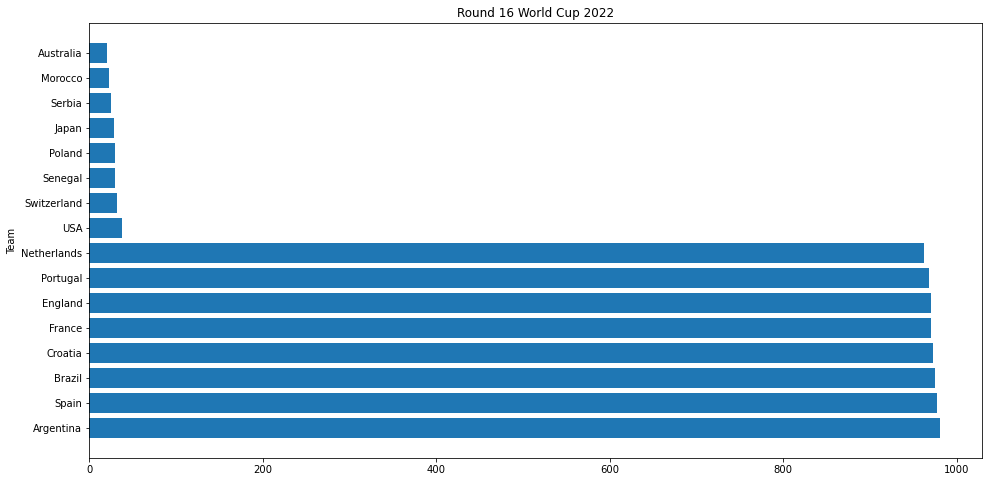

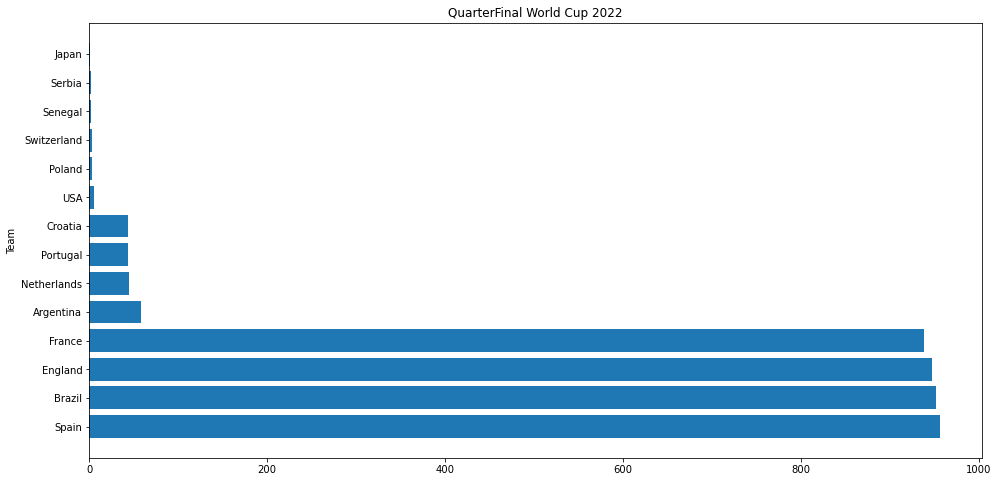

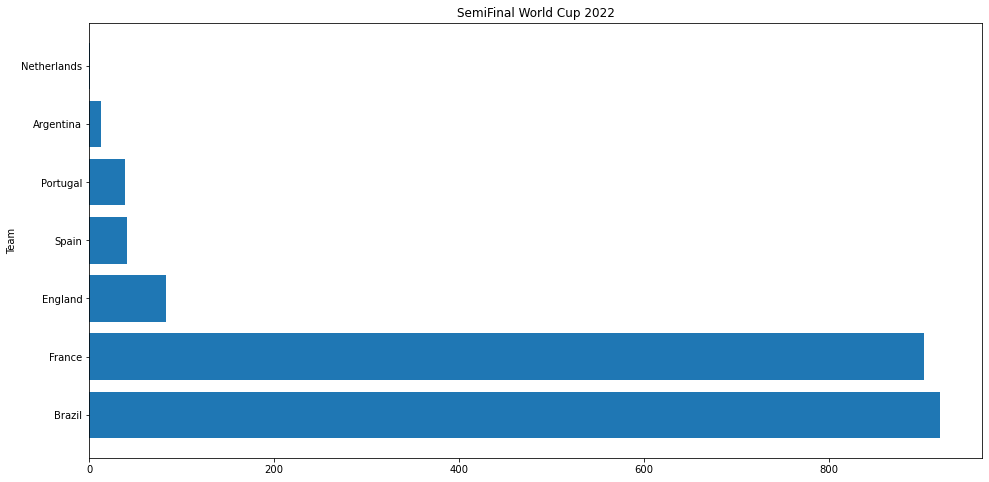

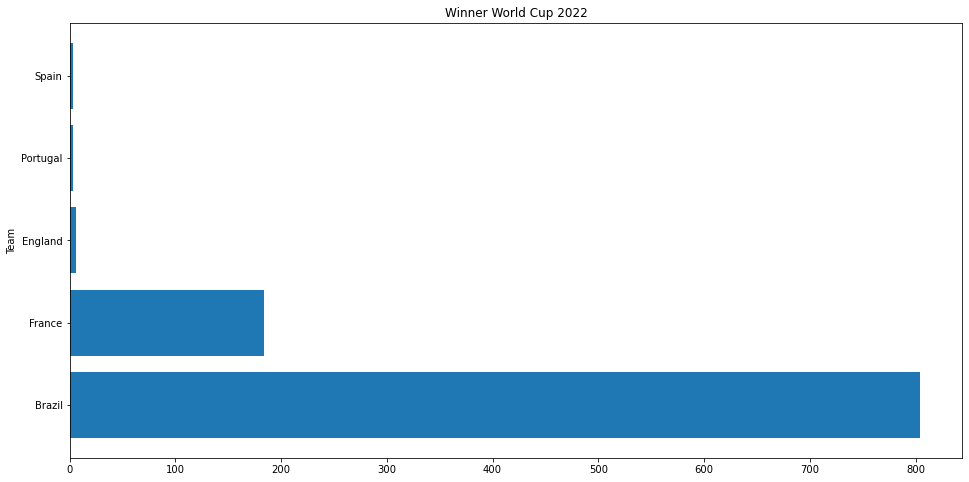

In [75]:
from collections import Counter
from matplotlib import figure

lst_results = [simulation_results_round16,simulation_results_quarterfinal,simulation_results_semifinal,simulations_winners]
for i in lst_results:
    results = Counter(i).most_common()
    x,y = zip(*results)

    fig,ax = plt.subplots(figsize=(16,8))

    ax.barh(x, y)

    ax.set_ylabel('Team')

    if i == simulation_results_round16:
        ax.set_title('Round 16 World Cup 2022')
    if i == simulation_results_quarterfinal:
        ax.set_title('QuarterFinal World Cup 2022')
    if i == simulation_results_semifinal:
        ax.set_title('SemiFinal World Cup 2022')
    if i == simulations_winners:
        ax.set_title('Winner World Cup 2022')

        
    plt.show()

In [76]:
# df_result = df_results.reset_index(drop = True)
# for i in range(0, len(df_result)):
#     df_result['Prob'] = df_result['Prob'][i][0]

In [77]:
# #Join all data in onw single view
# import seaborn as sns

# sns.set_theme(style="whitegrid")
# sns.set(rc={'figure.figsize':(20,10)})

# # Draw a nested barplot by Team and Step
# g = sns.barplot(data=df_result, x="Team",y='Prob', hue="Step", estimator=sum, palette="dark", alpha=.7)

### Top 6 Teams to win the 2022 Qatar World Cup

In [80]:
winner = pd.DataFrame(results, columns = ['Country/Team', 'Win %'])
winner.index += 1
winner['Win %'] = (np.round((winner['Win %'] / winner['Win %'].sum()).mul(100), 3)).astype('str') + '%'
winner.head(5)

,Country/Team,Win %
1,Brazil,80.4%
2,France,18.4%
3,England,0.6%
4,Portugal,0.3%
5,Spain,0.3%


### Deleting the Endpoint

In [79]:
sagemaker.Session().delete_endpoint(predictor.endpoint)
bucket_to_delete = boto3.resource('s3').Bucket(bucket_name)
bucket_to_delete.objects.all().delete()

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Deleting endpoint with name: xgboost-2023-01-03-00-27-57-004
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


[{'ResponseMetadata': {'RequestId': 'DAXYQVS5VVR7GR3R',
   'HostId': 'f8OkYK5J6HSXgQdj6F66gLdrlfZq94rhZoi+IJW/YbfuK/XOl5AgX5VH63rKKHynP19GNCNnQcU=',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': 'f8OkYK5J6HSXgQdj6F66gLdrlfZq94rhZoi+IJW/YbfuK/XOl5AgX5VH63rKKHynP19GNCNnQcU=',
    'x-amz-request-id': 'DAXYQVS5VVR7GR3R',
    'date': 'Tue, 03 Jan 2023 00:33:14 GMT',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3',
    'connection': 'close'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'model/xgboost-2023-01-02-23-35-43-864/profiler-output/system/training_job_end.ts'},
   {'Key': 'model/sagemaker-xgboost-2023-01-02-23-23-22-411/debug-output/events/000000000340/000000000340_worker_0.tfevents'},
   {'Key': 'model/sagemaker-xgboost-2023-01-02-23-23-22-411/debug-output/index/000000000/000000000060_worker_0.json'},
   {'Key': 'model/xgboost-2023-01-03-00-08-05-144/profiler-output/system/training_job_end.ts'},
   {'Key': 'model/sag